# NBA Player Archetype Clustering
**Objective:** Group 2022 NBA players into four statistical archetypes using K-Means clustering.

In [1]:
# Imports & threadpoolctl patch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
import threadpoolctl, contextlib
from sklearn.decomposition import PCA

# Avoid BLAS/threadpool errors
threadpoolctl.threadpool_limits = lambda *args, **kwargs: contextlib.nullcontext()


## 1. Load the Dataset
Semicolon-delimited CSV with per-game stats for each player.

In [2]:
df = pd.read_csv('seasonstats.csv', sep=';', encoding='latin-1')

df.head()


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9


## 2. Pre processing
Ensure our core features are complete.


In [3]:
#Handle missing values
missing = df.isnull().sum()
missing[missing > 0]

# Handling name inconsistencies
df['Player'] = (
    df['Player']
      .str.replace('Porzi\\?\\?is', 'Porziņģis', regex=True)
      .str.replace('Don\\?i\\?', 'Dončić', regex=True)
)


## 3. Feature Selection & Scaling
We’ll cluster on PTS, AST, TRB, STL, BLK, FG%, 3P%, FT%.


In [4]:
features = ['PTS','AST','TRB','STL','BLK','FG%','3P%','FT%']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame(X_scaled, columns=features).head()


,PTS,AST,TRB,STL,BLK,FG%,3P%,FT%
0,0.209896,-0.385559,1.347449,-0.194639,0.683406,0.085997,0.523628,-0.223310
1,-0.148744,0.866518,2.835943,0.746117,1.238055,0.813597,-1.756004,-0.406850
2,1.840075,0.866518,2.878472,1.922062,1.238055,0.880967,-1.756004,0.334371
3,-0.605194,-0.603311,-0.268631,-0.900206,-0.148567,-0.163274,-0.962260,-0.117421
4,0.829364,-0.494435,0.922165,-0.665017,1.792703,0.833808,0.174381,0.757926


## 4. Choosing k via Elbow Plot
Plot inertia for k=1…10.


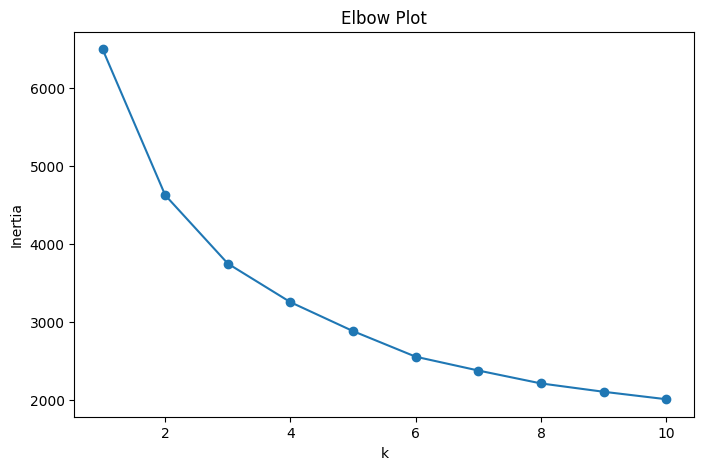

In [5]:
warnings.filterwarnings("ignore")
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    inertia.append(km.fit(X_scaled).inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), inertia, 'o-')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow Plot');
plt.show()


## 5. Cluster Assignment (k = 4)
Label each player and compute centroids.


In [6]:
km4 = KMeans(n_clusters=4, n_init=10, random_state=42)
labels = km4.fit_predict(X_scaled)
df['Cluster'] = labels

centroids = pd.DataFrame(
    scaler.inverse_transform(km4.cluster_centers_),
    columns=features
)
centroids['Cluster'] = centroids.index
centroids


,PTS,AST,TRB,STL,BLK,FG%,3P%,FT%,Cluster
0,5.366745,1.123585,2.404717,0.432075,0.233491,0.440868,0.304033,0.719120,0
1,15.898837,4.453488,4.708140,1.080233,0.395930,0.443448,0.348110,0.800762,1
2,10.351261,1.478992,6.527731,0.698319,0.951261,0.548378,0.246899,0.695983,2
3,1.049485,0.514433,1.021649,0.217526,0.070103,0.181907,0.065804,0.093330,3


## 6. Interpreting the Archetypes  
Map clusters → roles (e.g. “High-Usage Scorers,” “Rim-Running Bigs,” etc.).


In [7]:
names = {
    0: 'Spot-Up/Role Players',
    1: 'High-Usage Scorers & Playmakers',
    2: 'Rim-Running Bigs & Defenders',
    3: 'Bench/Low-Usage'
}
df['Role'] = df['Cluster'].map(names)

# Show counts
df['Role'].value_counts()


Role
Spot-Up/Role Players               424
High-Usage Scorers & Playmakers    172
Rim-Running Bigs & Defenders       119
Bench/Low-Usage                     97
Name: count, dtype: int64

## 7. Visualizing Clusters via PCA
Reduce to 2 dims and color by Role.


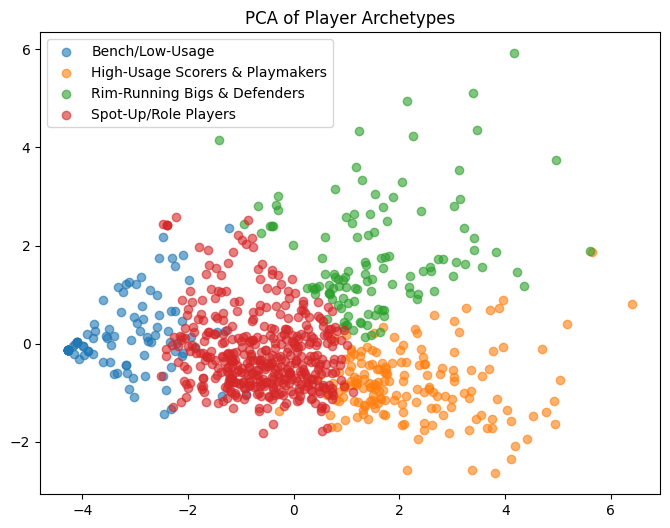

In [8]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
vis_df = pd.DataFrame(coords, columns=['PC1','PC2'])
vis_df['Role'] = df['Role']

plt.figure(figsize=(8,6))
for role, grp in vis_df.groupby('Role'):
    plt.scatter(grp.PC1, grp.PC2, label=role, alpha=0.6)
plt.legend(); plt.title('PCA of Player Archetypes'); plt.show()


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=['PC1', 'PC2']
)
print(loadings)


          PC1       PC2
PTS  0.462050 -0.098530
AST  0.381484 -0.330306
TRB  0.409756  0.381617
STL  0.393104 -0.198248
BLK  0.316913  0.554431
FG%  0.255006  0.384108
3P%  0.239795 -0.415895
FT%  0.309169 -0.261447


## 8. Profiling Clusters
Compute average stats per archetype and find top 5 scorers in each archetype

In [10]:
# Compute average stats per archetype
avg_stats = df.groupby('Role')[features].mean().round(2).reset_index()

# Find top 5 scorers in each archetype
top_scorers = {}
for role in df['Role'].unique():
    top_scorers[role] = (
        df[df['Role'] == role]
        .sort_values('PTS', ascending=False)[['Player', 'Tm', 'Pos', 'PTS']]
        .head(5)
    )

# Print the results
print("Average Stats by Archetype:")
print(avg_stats.to_string(index=False))

print("\nTop 5 Scorers per Archetype:")
for role, table in top_scorers.items():
    print(f"\n{role}")
    print(table.to_string(index=False))

Average Stats by Archetype:
                           Role   PTS  AST  TRB  STL  BLK  FG%  3P%  FT%
                Bench/Low-Usage  1.05 0.51 1.02 0.22 0.07 0.18 0.07 0.09
High-Usage Scorers & Playmakers 15.90 4.45 4.71 1.08 0.40 0.44 0.35 0.80
   Rim-Running Bigs & Defenders 10.35 1.48 6.53 0.70 0.95 0.55 0.25 0.70
           Spot-Up/Role Players  5.37 1.12 2.40 0.43 0.23 0.44 0.30 0.72

Top 5 Scorers per Archetype:

Rim-Running Bigs & Defenders
            Player  Tm Pos  PTS
       Joel Embiid PHI   C 30.6
Karl-Anthony Towns MIN   C 24.6
     Anthony Davis LAL   C 23.2
Kristaps Porziņģis WAS  PF 22.1
Kristaps Porziņģis TOT  PF 20.2

Spot-Up/Role Players
          Player  Tm Pos  PTS
 De'Andre Hunter ATL  SF 13.4
     Eric Gordon HOU  SG 13.4
      Coby White CHI  PG 12.7
Lonnie Walker IV SAS  SG 12.1
   Malik Beasley MIN  SG 12.1

High-Usage Scorers & Playmakers
               Player  Tm Pos  PTS
         LeBron James LAL  SF 30.3
Giannis Antetokounmpo MIL  PF 29.9
         Kevin 

# Cell 9: OOP Wrappers for Players & Clusters

In [11]:
# Define Classes
class Player:
    def __init__(self, name, team, position, stats):
        self.name = name
        self.team = team
        self.position = position
        self.stats = stats
        self.role = None

    def assign_role(self, role_name):
        self.role = role_name
        
    def __repr__(self):
        return f"{self.name} ({self.team}, {self.position}) → {self.role}"

class PlayerCluster:
    def __init__(self, name, centroid_values, features):
        self.name = name
        # Map feature names to centroid values
        self.centroid = dict(zip(features, centroid_values))
        self.members = []

    def add_member(self, player: Player):
        player.assign_role(self.name)
        self.members.append(player)
        
    def summary(self):
        lines = [f"Cluster: {self.name}", "Centroid stats:"]
        for feat, val in self.centroid.items():
            lines.append(f"  {feat}: {val:.2f}")
        lines.append(f"Total members: {len(self.members)}")
        return "\n".join(lines)
    
    # Instantiate Cluster Objects 
clusters = {}
for idx, row in centroids.iterrows():
    role_name = names[idx]
    clusters[idx] = PlayerCluster(role_name, row[features].values, features)

# Instantiate Player Objects and Assign 
players = []
for _, row in df.iterrows():
    stats = {feat: row[feat] for feat in features}
    player = Player(row['Player'], row['Tm'], row['Pos'], stats)
    players.append(player)
    clusters[row['Cluster']].add_member(player)

# Display summaries
for cl in clusters.values():
    print(cl.summary())
    print(" Top members:", cl.members[:3], "\n")

Cluster: Spot-Up/Role Players
Centroid stats:
  PTS: 5.37
  AST: 1.12
  TRB: 2.40
  STL: 0.43
  BLK: 0.23
  FG%: 0.44
  3P%: 0.30
  FT%: 0.72
Total members: 424
 Top members: [Santi Aldama (MEM, PF) → Spot-Up/Role Players, Nickeil Alexander-Walker (TOT, SG) → Spot-Up/Role Players, Nickeil Alexander-Walker (UTA, SG) → Spot-Up/Role Players] 

Cluster: High-Usage Scorers & Playmakers
Centroid stats:
  PTS: 15.90
  AST: 4.45
  TRB: 4.71
  STL: 1.08
  BLK: 0.40
  FG%: 0.44
  3P%: 0.35
  FT%: 0.80
Total members: 172
 Top members: [Nickeil Alexander-Walker (NOP, SG) → High-Usage Scorers & Playmakers, Giannis Antetokounmpo (MIL, PF) → High-Usage Scorers & Playmakers, Cole Anthony (ORL, PG) → High-Usage Scorers & Playmakers] 

Cluster: Rim-Running Bigs & Defenders
Centroid stats:
  PTS: 10.35
  AST: 1.48
  TRB: 6.53
  STL: 0.70
  BLK: 0.95
  FG%: 0.55
  3P%: 0.25
  FT%: 0.70
Total members: 119
 Top members: [Precious Achiuwa (TOR, C) → Rim-Running Bigs & Defenders, Steven Adams (MEM, C) → Rim-R